In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import gzip as gz
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import glob
from joblib import Parallel, delayed
import sys
import argparse
import plotly.express as px
import plotly.io as pio
import os
from Bio.Seq import Seq
from Bio import SeqIO
import swifter
import sys
import plotly.express as px
from Levenshtein import distance
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv("shuttlecock_positions/TC_00001.shuttlecock_pos.csv")

In [16]:
df.head()

,frame,x,y,prob
0,0,1180,298,0.432867
1,0,448,474,0.411632
2,1,1183,298,0.547050
3,1,447,474,0.415733
4,2,1187,298,0.460242


In [17]:
df = df.merge(df.groupby(['x','y']).size().reset_index(),left_on=["x","y"],right_on=["x","y"],how="left")

In [18]:
df

,frame,x,y,prob,0
0,0,1180,298,0.432867,1
1,0,448,474,0.411632,5
2,1,1183,298,0.547050,1
3,1,447,474,0.415733,4
4,2,1187,298,0.460242,2
...,...,...,...,...,...
94969,35052,334,216,0.349113,1
94970,35054,325,244,0.345318,1
94971,35054,314,154,0.223971,1
94972,35055,322,256,0.392399,1


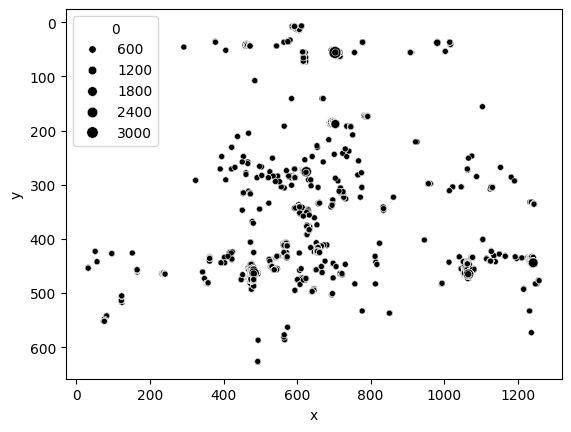

In [28]:
sns.scatterplot(data=df[df[0]>2],x='x',y='y',size=0,color="black")
plt.gca().invert_yaxis()

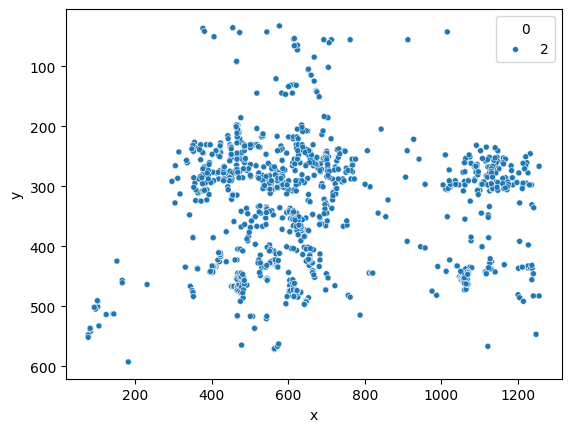

In [29]:
sns.scatterplot(data=df[df[0]==2],x='x',y='y',size=0)
plt.gca().invert_yaxis()

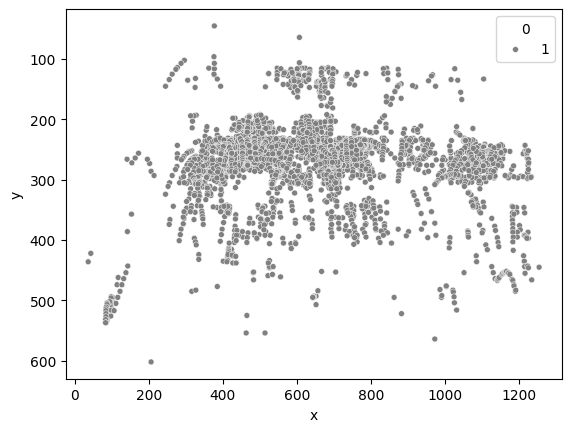

In [33]:
sns.scatterplot(data=df[(df[0]==1)&(df['prob']>0.6)],x='x',y='y',size=0,color="grey")
plt.gca().invert_yaxis()

<AxesSubplot:>

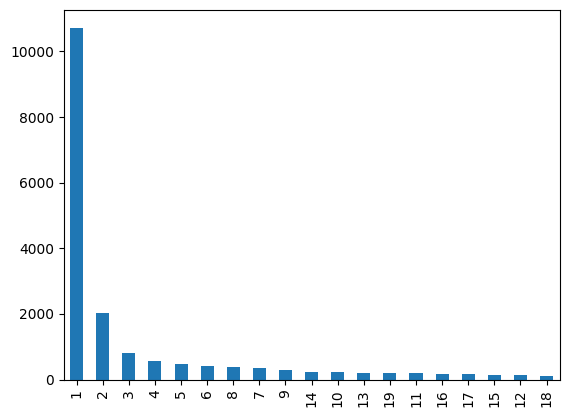

In [47]:
df[df[0]<20][0].value_counts().plot(kind='bar')

# looks like 2 is a good cutoff

In [22]:
df[df[0]==2]

,frame,x,y,prob,0
4,2,1187,298,0.460242,2
52,29,452,467,0.396106,2
53,30,452,467,0.385748,2
54,30,1202,437,0.215804,2
56,31,1202,437,0.253486,2
...,...,...,...,...,...
94733,34919,1134,285,0.417385,2
94744,34922,483,473,0.442336,2
94754,34926,481,478,0.379049,2
94829,34962,942,255,0.480332,2


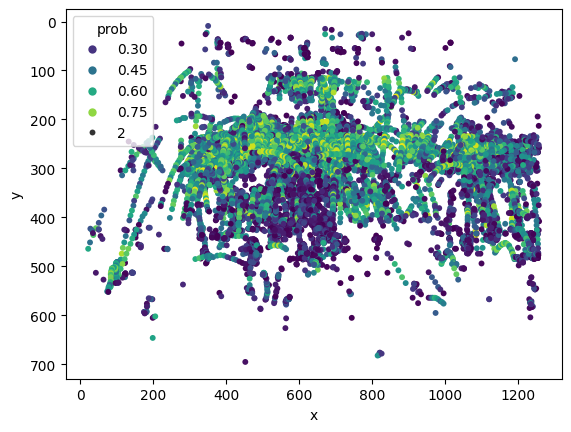

In [56]:
sns.scatterplot(data=df[df[0]<=2],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2)
plt.gca().invert_yaxis()

# other people are playing at x=200 and x=1000, can we use clustering to find out?

In [57]:
df = df[df[0]<=2]

In [58]:
df.shape

(12752, 5)

In [59]:
df.head()

,frame,x,y,prob,0
0,0,1180,298,0.432867,1
2,1,1183,298,0.547050,1
4,2,1187,298,0.460242,2
6,3,1191,298,0.429008,1
8,4,447,475,0.395821,1


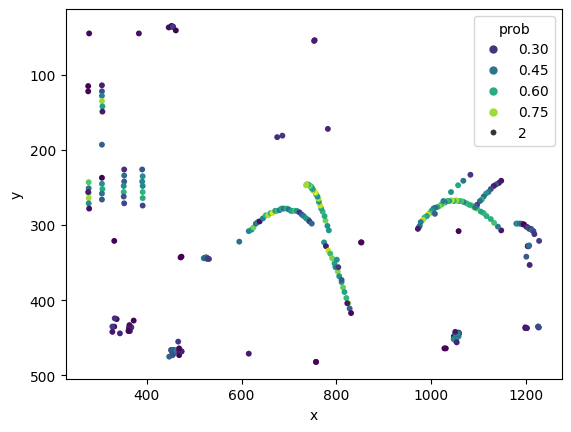

In [60]:
sns.scatterplot(data=df[df['frame']<=1000],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2)
plt.gca().invert_yaxis()

In [61]:
start = 13*60
df = df[df.frame>start]

# every captured shuttlecock

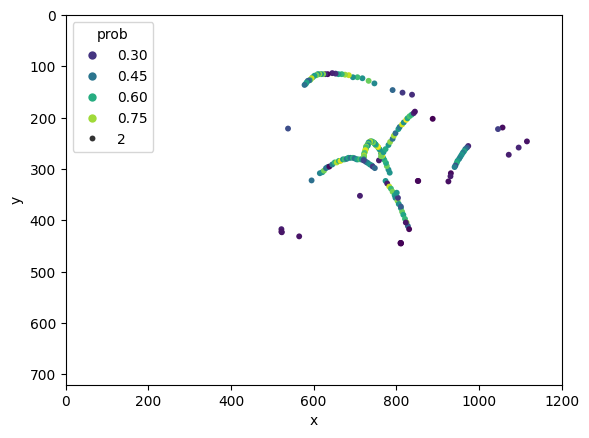

In [70]:
n=6
fps=60
sns.scatterplot(data=df[df['frame'].between(start,start+n*fps)],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()

# cleaned

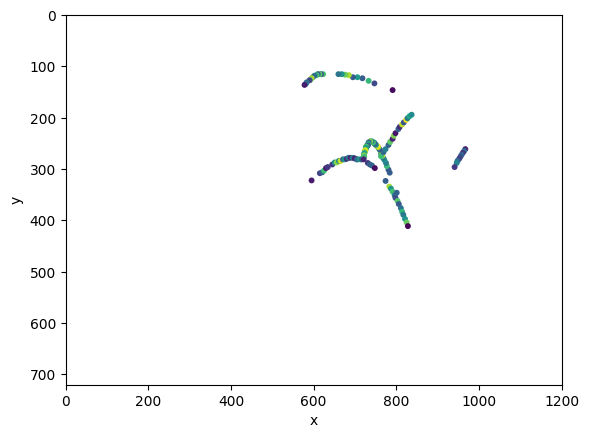

In [73]:
n=6
fps=60
sns.scatterplot(data=df[df['frame'].between(start,start+n*fps)&(df.prob>0.4)],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2,legend=None)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()

# Good, we didn't miss any lines

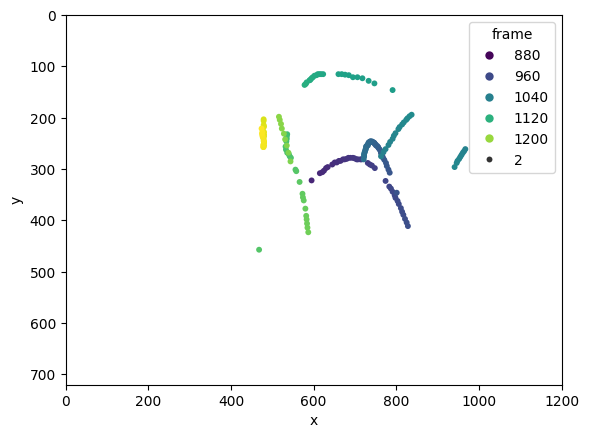

In [76]:
n=8
fps=60
sns.scatterplot(data=df[df['frame'].between(start,start+n*fps)&(df.prob>0.4)],x='x',y='y',hue="frame",palette="viridis",linewidth=0,size=2)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'intermiate phase, between someone begin to serve')

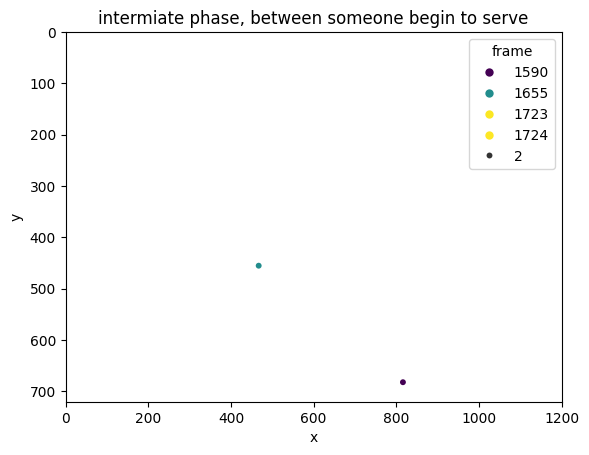

In [78]:

sns.scatterplot(data=df[df['frame'].between(26*fps,30*fps)&(df.prob>0.4)],x='x',y='y',hue="frame",palette="viridis",linewidth=0,size=2)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()
plt.title("intermiate phase, between someone begin to serve")

# curve estimation

In [80]:
df.frame.value_counts()

19831    4
23324    4
28183    4
23361    4
25683    3
        ..
12672    1
12673    1
12674    1
12675    1
35056    1
Name: frame, Length: 11403, dtype: int64

In [88]:
df = pd.read_csv("shuttlecock_positions/TC_00001.shuttlecock_pos.csv")
df = df.merge(df.groupby(['x','y']).size().reset_index(),left_on=["x","y"],right_on=["x","y"],how="left")
df = df[df[0]<=2]
start = 13*60
df = df[df.frame>start]
df = df[df['prob']>0.4]
df = df.sort_values("prob",ascending=False)
df = df.drop_duplicates("frame")
df['Visibility']=1
frame_list = df.frame.tolist()
for i in range(df.frame.min(),df.frame.max()+10):
    if not i in frame_list:
        df.loc[-1] = [i,0,0,0,0,0]
        df.index = df.index + 1
df = df.sort_values("frame")
# fill in mssing frame and use the box
df.head()

,frame,x,y,prob,0,Visibility
28423,874,1226,435,0.402165,2,1
26713,875,0,0,0.000000,0,0
26712,876,0,0,0.000000,0,0
26711,877,0,0,0.000000,0,0
26710,878,0,0,0.000000,0,0


In [89]:
import pandas as pd
import numpy as np
import os
def smooth(df):
    #path = '41_predict.csv'
    # df = pd.read_csv(path)
    # df = df.fillna(0)

    x = df['x'].tolist()
    y = df['y'].tolist()
    vis = df['Visibility'].tolist()

    # Define distance
    pre_dif = []
    for i in range(0,len(x)):
        if i ==0:
            pre_dif.append(0)
        else:
            pre_dif.append(((x[i]-x[i-1])**2+(y[i]-y[i-1])**2)**(1/2)) 


    abnormal = [0]*len(pre_dif)
    X_abn = x
    y_abn = y
    dif_error = 2
    for i in range(len(pre_dif)):
        if i==len(pre_dif):
            abnormal[i]=0
        elif i==len(pre_dif)-1:
            abnormal[i]=0
        elif i==len(pre_dif)-2:
            abnormal[i]=0 
        elif i==len(pre_dif)-3:
            abnormal[i]=0
        elif pre_dif[i] >= 100 and pre_dif[i+1] >= 100:
            if vis[i:i+2] == [1,1]:# and series[i:i+2] == [1,1]:
                abnormal[i] ='bias1'
                X_abn[i] = 0
                y_abn[i] = 0
        elif pre_dif[i] >= 100 and pre_dif[i+2] >= 100:
            if pre_dif[i+1]<dif_error:
                if vis[i:i+3] == [1,1,1]:# and series[i:i+3] == [1,1,1]:
                    abnormal[i:i+2]=['bias2','bias2']
                    X_abn[i:i+2] = [0,0]
                    y_abn[i:i+2] = [0,0]
        elif pre_dif[i] >= 100 and pre_dif[i+3] >= 100:
            if pre_dif[i+1]<dif_error and pre_dif[i+2]<dif_error:
                if vis[i:i+4] == [1,1,1,1]:# and series[i:i+4] == [1,1,1,1]:
                    abnormal[i:i+3]=['bias3','bias3','bias3']
                    X_abn[i:i+3] = [0,0,0]
                    y_abn[i:i+3] = [0,0,0]
        elif pre_dif[i] >= 100 and pre_dif[i+4] >= 100:
            if pre_dif[i+1]<dif_error and pre_dif[i+2]<dif_error and pre_dif[i+3]<dif_error:
                if vis[i:i+5] == [1,1,1,1,1]:# and series[i:i+5] == [1,1,1,1,1]:
                    abnormal[i:i+4]=['bias4','bias4','bias4','bias4']
                    X_abn[i:i+4] = [0,0,0,0]
                    y_abn[i:i+4] = [0,0,0,0]


    # # II. Poly line check

    x_test = X_abn
    y_test = y_abn


    vis2 = [1] * len(df)
    for i in range(len(df)):
        if x_test[i] ==0 and y_test[i] ==0:
            vis2[i] = 0

    fuc2 = [0]*len(df)
    fuc1 = [0]*len(df)
    fuc0 = [0]*len(df)
    x_ck_bf = [0]*len(df)
    y_ck_bf = [0]*len(df)
    bf_dis = [0]*len(df)
    x_ck_af = [0]*len(df)
    y_ck_af = [0]*len(df)
    af_dis = [0]*len(df)

    for i in range(1,len(df)-7):
        if i==154:
            print(df.iloc[i:i+7])
            print(vis2[i:i+7])
            print('sum(vis2[i:i+7]) : {}'.format(sum(vis2[i:i+7])))
        if sum(vis2[i:i+7])>=2:
            vis_window = np.array(vis2[i:i+7])
            loc = np.where(vis_window==1)
            for k in loc:
                x_ar = np.array(x_test)[i+k]
                y_ar = np.array(y_test)[i+k]
            f1 = np.polyfit(x_ar, y_ar, 2)
            p1 = np.poly1d(f1)
            fuc2[i]=f1[0]
            fuc1[i]=f1[1]
            fuc0[i]=f1[2]
            
            if vis[i+7]==1:
                y_check_af=p1(x_test[i+7])
                x_ck_af[i+7]=x_test[i+7]
                y_ck_af[i+7]=y_check_af
                af_dis[i+7]=abs(y_check_af-y_test[i+7])
            elif vis[i+7]==0:
                x_ck_af[i+7]='NA'
                y_ck_af[i+7]='NA'
            if vis[i-1]==1:
                y_check_bf=p1(x_test[i-1])
                x_ck_bf[i-1]=x_test[i-1]
                y_ck_bf[i-1]=y_check_bf
                bf_dis[i-1]=abs(y_check_bf-y_test[i-1])
            elif vis[i-1]==0:
                x_ck_bf[i-1]='NA'
                y_ck_bf[i-1]='NA'



    # # III. 2nd Denoise

    x_test_2nd = X_abn
    y_test_2nd = y_abn
    abnormal2 = abnormal

    for i in range(len(df)):
        if af_dis[i]>30 and vis2[i]==1:
            if bf_dis[i]>30 and vis2[i]==1:
                x_test_2nd[i]=0
                y_test_2nd[i]=0
                abnormal2[i]='2bias1'
            elif bf_dis[i+1]>30 and vis2[i+1]==1:
                if af_dis[i+1]<30:
                    x_test_2nd[i:i+2]=[0,0]
                    y_test_2nd[i:i+2]=[0,0]
                    abnormal2[i:i+2]=['2bias2','2bias2']
            elif bf_dis[i+2]>30 and vis2[i+1:i+3]==[1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30:
                    x_test_2nd[i:i+3]=[0,0,0]
                    y_test_2nd[i:i+3]=[0,0,0]
                    abnormal2[i:i+3]=['2bias3','2bias3','2bias3']
            elif bf_dis[i+3]>30 and vis2[i+1:i+4]==[1,1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30 and af_dis[i+3]<30:
                    x_test_2nd[i:i+4]=[0,0,0,0]
                    y_test_2nd[i:i+4]=[0,0,0,0]
                    abnormal2[i:i+4]=['2bias4','2bias4','2bias4','2bias4']
        if i + 4 < len(df):
            if bf_dis[i+4]>30 and vis2[i+1:i+5]==[1,1,1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30 and af_dis[i+3]<30 and af_dis[i+4]<30:
                    x_test_2nd[i:i+5]=[0,0,0,0,0]
                    y_test_2nd[i:i+5]=[0,0,0,0,0]
                    abnormal2[i:i+5]=['2bias5','2bias5','2bias5','2bias5','2bias5']
        if i + 5 < len(df):
            if bf_dis[i+5]>30 and vis2[i+1:i+6]==[1,1,1,1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30 and af_dis[i+3]<30 and af_dis[i+4]<30 and af_dis[i+5]<30:
                    x_test_2nd[i:i+6]=[0,0,0,0,0,0]
                    y_test_2nd[i:i+6]=[0,0,0,0,0,0]
                    abnormal2[i:i+6]=['2bias6','2bias6','2bias6','2bias6','2bias6','2bias6']
                
        elif af_dis[i]>1000 and vis2[i]==1:
            x_test_2nd[i]=0
            y_test_2nd[i]=0
            abnormal2[i]='2bias1'
        
        elif bf_dis[i]>1000 and vis2[i]==1:
            x_test_2nd[i]=0
            y_test_2nd[i]=0
            abnormal2[i]='2bias1'


    # # IV. Compensate

    vis3 = [1] * len(df)
    for i in range(len(df)):
        if x_test_2nd[i] ==0 and y_test_2nd[i] ==0:
            # print('frame " {}'.format(i))
            vis3[i] = 0

    f2 = fuc2
    f1 = fuc1
    f0 = fuc0
    x_sm = x_test_2nd
    y_sm = y_test_2nd
    comp_ft = [0] * len(df)
    comp_bk = [0] * len(df)
    for i in range(len(vis3)):
        if af_dis[i]!=0 and bf_dis[i]!=0 and af_dis[i]<5 and bf_dis[i]<5:
            if sum(vis3[i-7:i])!=7: # front side compensate
                print(vis3[i-7:i])
                for k in range(5):
                    if vis3[i-7+k:i-4+k]==[1,0,1]:
                        x_ev = (x_sm[i-7+k]+x_sm[i-5+k])/2
                        y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                        x_sm[i-6+k]=x_ev
                        y_sm[i-6+k]=y_ev
                        
                        vis3[i-7+k:i-4+k]=[1,1,1]
                for k in range(4):
                    if vis3[i-7+k:i-3+k]==[1,0,0,1]:
                        for j in range(1,3):
                            x_ev = ((x_sm[i-4+k]-x_sm[i-7+k])/3)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                        
                        vis3[i-7+k:i-3+k]=[1,1,1,1]
                for k in range(3):
                    if vis3[i-7+k:i-2+k]==[1,0,0,0,1]:
                        for j in range(1,4):
                            x_ev = ((x_sm[i-3+k]-x_sm[i-7+k])/4)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                            
                        vis3[i-7+k:i-2+k]=[1,1,1,1,1]
                for k in range(2):
                    if vis3[i-7+k:i-1+k]==[1,0,0,0,0,1]:
                        for j in range(1,5):
                            x_ev = ((x_sm[i-2+k]-x_sm[i-7+k])/5)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                        
                        vis3[i-7+k:i-1+k]=[1,1,1,1,1,1]
                for k in range(1):
                    if vis3[i-7+k:i+k]==[1,0,0,0,0,0,1]:
                        for j in range(1,6):
                            x_ev = ((x_sm[i-1+k]-x_sm[i-7+k])/6)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                        
                        vis3[i-7+k:i+k]=[1,1,1,1,1,1,1]
                        
        
            if sum(vis3[i+1:i+8])!=7: # back side compensate
                print(vis3[i+1:i+8])
                for k in range(5):
                    if vis3[i+1+k:i+4+k]==[1,0,1]:
                        x_ev = (x_sm[i+1+k]+x_sm[i+3+k])/2
                        y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                        x_sm[i+2+k]=x_ev
                        y_sm[i+2+k]=y_ev
                        
                        vis3[i+1+k:i+4+k]=[1,1,1]
                for k in range(4):   
                    if vis3[i+1+k:i+5+k]==[1,0,0,1]:
                        for j in range(1,3):
                            x_ev = ((x_sm[i+4+k]-x_sm[i+1+k])/3)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+5+k]=[1,1,1,1]
                for k in range(3):   
                    if vis3[i+1+k:i+6+k]==[1,0,0,0,1]:
                        for j in range(1,4):
                            x_ev = ((x_sm[i+5+k]-x_sm[i+1+k])/4)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+6+k]=[1,1,1,1,1]
                for k in range(2):  
                    if vis3[i+1+k:i+7+k]==[1,0,0,0,0,1]:
                        for j in range(1,5):
                            x_ev = ((x_sm[i+6+k]-x_sm[i+1+k])/5)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+7+k]=[1,1,1,1,1,1]
        
                for k in range(1):  
                    if vis3[i+1+k:i+8+k]==[1,0,0,0,0,0,1]:
                        for j in range(1,5):
                            x_ev = ((x_sm[i+7+k]-x_sm[i+1+k])/6)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+8+k]=[1,1,1,1,1,1,1]


    # # V. 2nd Compensate

    vis4 = [1] * len(df)
    for i in range(len(df)):
        if x_sm[i] ==0 and y_sm[i] ==0:
            vis4[i] = 0

    mis1 = []
    mis2 = []
    mis3 = []
    mis4 = []
    mis5 = []
    for i in range(len(vis4)):
        if i == 0:
            mis1.append(0)
        elif vis4[i-1:i+2] == [1,0,1]:
            mis1.append(1)
        elif i == len(vis4):
            mis1.append(0)
        else:
            mis1.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis2.append(0)
        elif vis4[i-1:i+3] == [1,0,0,1]:
            mis2.append(1)
        elif i == len(vis4)-1:
            mis2.append(0)
        elif i == len(vis4):
            mis2.append(0)
        else:
            mis2.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis3.append(0)
        elif vis4[i-1:i+4] == [1,0,0,0,1]:
            mis3.append(1)
        elif i == len(vis4)-2:
            mis3.append(0)
        elif i == len(vis4)-1:
            mis3.append(0)
        elif i == len(vis4):
            mis3.append(0)
        else:
            mis3.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis4.append(0)
        elif vis4[i-1:i+5] == [1,0,0,0,0,1]:
            mis4.append(1)
        elif i == len(vis4)-3:
            mis4.append(0)
        elif i == len(vis4)-2:
            mis4.append(0)
        elif i == len(vis4)-1:
            mis4.append(0)
        elif i == len(vis4):
            mis4.append(0)
        else:
            mis4.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis5.append(0)
        elif vis4[i-1:i+6] == [1,0,0,0,0,0,1]:
            mis5.append(1)
        elif i == len(vis4)-4:
            mis5.append(0)
        elif i == len(vis4)-3:
            mis5.append(0)
        elif i == len(vis4)-2:
            mis5.append(0)
        elif i == len(vis4)-1:
            mis5.append(0)
        elif i == len(vis4):
            mis5.append(0)
        else:
            mis5.append(0)


    x_sm2 = x_sm
    y_sm2 = y_sm


    mis1_X = []
    mis1_y = []
    for i in range(len(mis1)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis1) or i ==len(mis1)-1 or i ==len(mis1)-2:
            mis1_X.append(x_sm2[i])
            mis1_y.append(y_sm2[i])        
        elif mis1[i] == 0:
            mis1_X.append(x_sm2[i])
            mis1_y.append(y_sm2[i])
        elif mis1[i] ==1:
            miss_point = i

            num_X = [x_sm2[miss_point-1],x_sm2[miss_point+1]]
            num_y = [y_sm2[miss_point-1],y_sm2[miss_point+1]]
            x_mis1 = np.array(num_X) 
            y_mis1 = np.array(num_y)
            

            f1 = np.polyfit(x_mis1, y_mis1, 1)
            p1 = np.poly1d(f1)
            yvals = p1(x)

            insert_X = (x_sm2[miss_point-1]+x_sm2[miss_point+1])/2
            insert_y = np.polyval(f1, insert_X)
            mis1_X.append(insert_X)
            mis1_y.append(insert_y)
        else:
            mis1_X.append(x_sm2[i])
            mis1_y.append(y_sm2[i])

    mis2_X = []
    mis2_y = []
    for i in range(len(mis2)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis2) or i ==len(mis2)-1 or i ==len(mis2)-2:
            mis2_X.append(mis1_X[i])
            mis2_y.append(mis1_y[i])        
        
        elif mis2[i] == 0 and mis2[i-1]==0:
            mis2_X.append(mis1_X[i])
            mis2_y.append(mis1_y[i])    

        elif mis2[i] ==1:
            miss_point = i
            print(len(mis1_X))
            if mis1_X[miss_point-3]!=0 and mis1_X[miss_point-2]!=0 and mis1_X[miss_point-1]!=0 and mis1_X[miss_point+2]!=0 and mis1_X[miss_point+3]!=0 and mis1_X[miss_point+4]!=0:
                num_X = [mis1_X[miss_point-3],mis1_X[miss_point-2],mis1_X[miss_point-1],mis1_X[miss_point+2],mis1_X[miss_point+3],mis1_X[miss_point+4]]
                num_y = [mis1_y[miss_point-3],mis1_y[miss_point-2],mis1_y[miss_point-1],mis1_y[miss_point+2],mis1_y[miss_point+3],mis1_y[miss_point+4]]
                x_mis2 = np.array(num_X) 
                y_mis2 = np.array(num_y)

                f1 = np.polyfit(x_mis2, y_mis2, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)

                for j in range(1,3):
                    insert_X = ((mis1_X[miss_point+2]-mis1_X[miss_point-1])/3)*j+mis1_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis2_X.append(insert_X)
                    mis2_y.append(insert_y)
            else:
                mis2_X.append(mis1_X[i])
                mis2_y.append(mis1_y[i])
                mis2_X.append(mis1_X[i+1])
                mis2_y.append(mis1_y[i+1])


    mis3_X = []
    mis3_y = []
    for i in range(len(mis3)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis3) or i ==len(mis3)-1 or i ==len(mis3)-2:
            mis3_X.append(mis2_X[i])
            mis3_y.append(mis2_y[i])        
     
        elif mis3[i-2:i+1] == [0,0,0]:
            mis3_X.append(mis2_X[i])
            mis3_y.append(mis2_y[i])    

        elif mis3[i] ==1:
            miss_point = i
            if mis2_X[miss_point-3]!=0 and mis2_X[miss_point-2]!=0 and mis2_X[miss_point-1]!=0 and mis2_X[miss_point+3]!=0 and mis2_X[miss_point+4]!=0 and mis1_X[miss_point+5]!=0:
                num_X = [mis2_X[miss_point-3],mis2_X[miss_point-2],mis2_X[miss_point-1],mis2_X[miss_point+3],mis2_X[miss_point+4],mis2_X[miss_point+5]]
                num_y = [mis2_y[miss_point-3],mis2_y[miss_point-2],mis2_y[miss_point-1],mis2_y[miss_point+3],mis2_y[miss_point+4],mis2_y[miss_point+5]]
                x_mis3 = np.array(num_X) 
                y_mis3 = np.array(num_y)

                f1 = np.polyfit(x_mis3, y_mis3, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)

                for j in range(1,4):
                    insert_X = ((mis2_X[miss_point+3]-mis2_X[miss_point-1])/4)*j+mis2_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis3_X.append(insert_X)
                    mis3_y.append(insert_y)
            else:
                mis3_X.append(mis2_X[i])
                mis3_y.append(mis2_y[i])
                mis3_X.append(mis2_X[i+1])
                mis3_y.append(mis2_y[i+1])
                mis3_X.append(mis2_X[i+2])
                mis3_y.append(mis2_y[i+2])
            


    mis4_X = []
    mis4_y = []
    for i in range(len(mis4)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis4) or i ==len(mis4)-1 or i ==len(mis4)-2:
            mis4_X.append(mis3_X[i])
            mis4_y.append(mis3_y[i])           
        elif mis4[i-3:i+1] == [0,0,0,0]:
            mis4_X.append(mis3_X[i])
            mis4_y.append(mis3_y[i])    

        elif mis4[i] ==1:
            miss_point = i
            if mis3_X[miss_point-3]!=0 and mis3_X[miss_point-2]!=0 and mis3_X[miss_point-1]!=0 and mis3_X[miss_point+4]!=0 and mis3_X[miss_point+5]!=0 and mis3_X[miss_point+6]!=0:
                num_X = [mis3_X[miss_point-3],mis3_X[miss_point-2],mis3_X[miss_point-1],mis3_X[miss_point+4],mis3_X[miss_point+5],mis3_X[miss_point+6]]
                num_y = [mis3_y[miss_point-3],mis3_y[miss_point-2],mis3_y[miss_point-1],mis3_y[miss_point+4],mis3_y[miss_point+5],mis3_y[miss_point+6]]
                x_mis4 = np.array(num_X) 
                y_mis4 = np.array(num_y)

                f1 = np.polyfit(x_mis4, y_mis4, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)


                for j in range(1,5):
                    insert_X = ((mis3_X[miss_point+4]-mis3_X[miss_point-1])/5)*j+mis3_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis4_X.append(insert_X)
                    mis4_y.append(insert_y)
            else:
                mis4_X.append(mis3_X[i])
                mis4_y.append(mis3_y[i])
                mis4_X.append(mis3_X[i+1])
                mis4_y.append(mis3_y[i+1])
                mis4_X.append(mis3_X[i+2])
                mis4_y.append(mis3_y[i+2])
                mis4_X.append(mis3_X[i+3])
                mis4_y.append(mis3_y[i+3])



    mis5_X = []
    mis5_y = []
    for i in range(len(mis5)):
        if i == 0 or i == 1 or i ==2 or i==3 or i ==len(mis5) or i ==len(mis5)-1 or i ==len(mis5)-2:
            mis5_X.append(mis4_X[i])
            mis5_y.append(mis4_y[i])           
        elif mis5[i-4:i+1] == [0,0,0,0,0]:
            mis5_X.append(mis4_X[i])
            mis5_y.append(mis4_y[i])    

        elif mis5[i] ==1:
            miss_point = i
            if mis4_X[miss_point-3]!=0 and mis4_X[miss_point-2]!=0 and mis4_X[miss_point-1]!=0 and mis4_X[miss_point+5]!=0 and mis4_X[miss_point+6]!=0 and mis4_X[miss_point+7]!=0:
                num_X = [mis4_X[miss_point-3],mis4_X[miss_point-2],mis4_X[miss_point-1],mis4_X[miss_point+5],mis4_X[miss_point+6],mis4_X[miss_point+7]]
                num_y = [mis4_y[miss_point-3],mis4_y[miss_point-2],mis4_y[miss_point-1],mis4_y[miss_point+5],mis4_y[miss_point+6],mis4_y[miss_point+7]]
                x_mis5 = np.array(num_X) 
                y_mis5 = np.array(num_y)

                f1 = np.polyfit(x_mis5, y_mis5, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)


                for j in range(1,6):
                    insert_X = ((mis4_X[miss_point+5]-mis4_X[miss_point-1])/6)*j+mis4_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis5_X.append(insert_X)
                    mis5_y.append(insert_y)
            else:
                mis5_X.append(mis4_X[i])
                mis5_y.append(mis4_y[i])
                mis5_X.append(mis4_X[i+1])
                mis5_y.append(mis4_y[i+1])
                mis5_X.append(mis4_X[i+2])
                mis5_y.append(mis4_y[i+2])
                mis5_X.append(mis4_X[i+3])
                mis5_y.append(mis4_y[i+3])
                mis5_X.append(mis4_X[i+4])
                mis5_y.append(mis4_y[i+4])

    df['new_X'] = mis5_X
    df['new_Y'] = mis5_y
    return df


In [90]:
df2 = smooth(df)

       frame  x  y  prob  0  Visibility
26640   1028  0  0   0.0  0           0
26639   1029  0  0   0.0  0           0
26638   1030  0  0   0.0  0           0
26637   1031  0  0   0.0  0           0
26636   1032  0  0   0.0  0           0
26635   1033  0  0   0.0  0           0
26634   1034  0  0   0.0  0           0
[0, 0, 0, 0, 0, 0, 0]
sum(vis2[i:i+7]) : 0
[0, 0, 0, 1, 0, 0, 1]
[1, 1, 1, 0, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 1]
[1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1]
[1, 1, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0]

In [92]:
df2.to_csv("shuttlecock_positions/TC_00001.denoised.shuttlecock_pos.csv",index=False)

In [ ]:
!python event_detection.py --input_csv shuttlecock_positions/TC_00001.denoised.shuttlecock_pos.csv

In [ ]:
tmp = pd.read_csv("shuttlecock_positions/TC_00001.denoised.shuttlecock_pos_event.csv")